In [38]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import math
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import StandardScaler


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
from load_data import prepare_data, aggregate_market_data
from models import CustomTransformerTimeSeries
from dataloader import TimeSeriesDataset

In [40]:
from_year = "1999"
end_year = "2019"
start_year_test = "2020"

In [41]:
data = aggregate_market_data()
df_reindexed, df_orig = prepare_data(data, from_year = from_year, start_year_test = start_year_test)

100%|██████████| 141/141 [00:00<00:00, 227.73it/s]


In [42]:
# hyperparameters

# diffusion hyperparameters
timesteps = 200
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
input_size = 300
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = df_reindexed.shape[1] 
save_dir = './weights/'

# training hyperparameters
batch_size = 32
n_epoch = 20
lrate=1e-3

In [43]:
# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] = 1

In [44]:
model = CustomTransformerTimeSeries(input_size=input_size, n_feat=n_feat, hidden_size=32, num_layers=2, num_heads=2, dropout_prob=0.1)

C:\Users\borch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [45]:
train_df = df_reindexed.loc[:'2019']
train_df = train_df.interpolate(method='nearest')
X_train = train_df.to_numpy()
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)

In [46]:
X_train.shape

torch.Size([5477, 53])

In [47]:
train_dataset = TimeSeriesDataset(X_train, seq_len=input_size)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)

optim = torch.optim.Adam(model.parameters(), lr=lrate)

In [48]:
# helper function: perturbs an time serie to a specified noise level
def perturb_input(x, t, noise):
    return ab_t.sqrt()[t, None, None] * x + (1 - ab_t[t, None, None]) * noise

In [49]:
# Initialize lists to store metrics
losses = []
maes = []
wasserstein_distances = []

for ep in range(n_epoch):
    print(f'epoch {ep}')
    
    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)
    pbar = tqdm(train_loader, mininterval=2 )    
    for x in pbar:   
        optim.zero_grad()
        x = x.to(device)
        # perturb data
  

        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device) 
        x_pert = perturb_input(x, t, noise)
        # use network to recover noise
        t = t.reshape(-1,1)
        pred_noise = model(x_pert, t / timesteps)
        
        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        loss.backward()
        
        optim.step()

        # Calculate MAE and Wasserstein distance
        mae = F.l1_loss(pred_noise, noise).item()
        w_dist = wasserstein_distance(pred_noise.flatten().detach().cpu().numpy(), noise.flatten().cpu().numpy())

        # Store metrics
        losses.append(loss.item())
        maes.append(mae)
        wasserstein_distances.append(w_dist)

    # save model periodically
    if ep%4==0 or ep == int(n_epoch-1):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        print(f'Loss: {loss.item()}, MAE: {mae}, Wasserstein Distance: {w_dist}')
        torch.save(model.state_dict(), save_dir + f"model_{ep}.pth")
        print('saved model at ' + save_dir + f"model_{ep}.pth")

epoch 0


100%|██████████| 162/162 [01:01<00:00,  2.62it/s]


Loss: 0.9037773609161377, MAE: 0.7560479640960693, Wasserstein Distance: 0.5285117813931933
saved model at ./weights/model_0.pth
epoch 1


100%|██████████| 162/162 [01:06<00:00,  2.42it/s]


epoch 2


100%|██████████| 162/162 [01:05<00:00,  2.47it/s]


epoch 3


100%|██████████| 162/162 [01:02<00:00,  2.58it/s]


epoch 4


100%|██████████| 162/162 [01:03<00:00,  2.54it/s]


Loss: 0.7375327348709106, MAE: 0.6756919622421265, Wasserstein Distance: 0.4274774403848344
saved model at ./weights/model_4.pth
epoch 5


100%|██████████| 162/162 [01:05<00:00,  2.47it/s]


epoch 6


100%|██████████| 162/162 [01:02<00:00,  2.57it/s]


epoch 7


100%|██████████| 162/162 [01:05<00:00,  2.49it/s]


epoch 8


100%|██████████| 162/162 [01:09<00:00,  2.34it/s]


Loss: 0.810789942741394, MAE: 0.7087622284889221, Wasserstein Distance: 0.47446307441052843
saved model at ./weights/model_8.pth
epoch 9


100%|██████████| 162/162 [01:05<00:00,  2.46it/s]


epoch 10


100%|██████████| 162/162 [01:02<00:00,  2.58it/s]


epoch 11


100%|██████████| 162/162 [01:13<00:00,  2.21it/s]


epoch 12


100%|██████████| 162/162 [01:18<00:00,  2.08it/s]


Loss: 0.7400219440460205, MAE: 0.6716932058334351, Wasserstein Distance: 0.45953777375963795
saved model at ./weights/model_12.pth
epoch 13


100%|██████████| 162/162 [01:06<00:00,  2.44it/s]


epoch 14


100%|██████████| 162/162 [01:09<00:00,  2.32it/s]


epoch 15


100%|██████████| 162/162 [01:01<00:00,  2.65it/s]


epoch 16


100%|██████████| 162/162 [01:02<00:00,  2.58it/s]


Loss: 0.7069545984268188, MAE: 0.6569581031799316, Wasserstein Distance: 0.4092933952068791
saved model at ./weights/model_16.pth
epoch 17


100%|██████████| 162/162 [01:01<00:00,  2.65it/s]


epoch 18


100%|██████████| 162/162 [01:00<00:00,  2.68it/s]


epoch 19


100%|██████████| 162/162 [01:08<00:00,  2.37it/s]

Loss: 0.7137517929077148, MAE: 0.6603038907051086, Wasserstein Distance: 0.4146223668561234
saved model at ./weights/model_19.pth


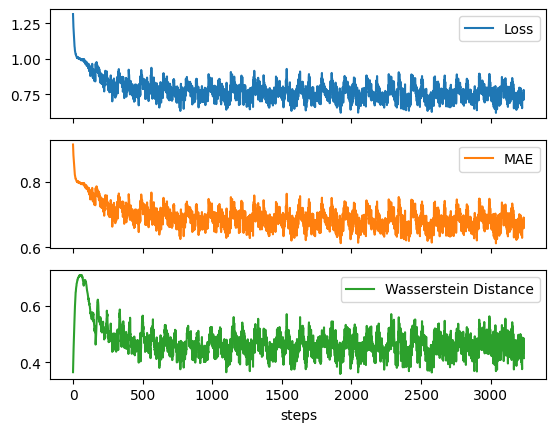

In [50]:
# Convert lists to DataFrame
metrics_df = pd.DataFrame({
    'Loss': losses,
    'MAE': maes,
    'Wasserstein Distance': wasserstein_distances
})

# Plot metrics
metrics_df.plot(subplots=True)
plt.xlabel('steps')
plt.show()

In [81]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [82]:
# sample using standard algorithm
@torch.no_grad()
def sample_ddpm(n_sample, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 300, n_feat).to(device) 

    # array to keep track of generated steps for plotting
    intermediate = [] 
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        # z must have the same mean and variance as the X_train


        # Generate a tensor with elements drawn from a standard normal distribution
        z = torch.randn_like(samples)  if i > 1 else 0


        eps = model(samples,t)    # predict noise e_(x_t,t)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate ==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [83]:
# load in model weights and set to eval mode
model.load_state_dict(torch.load(f"{save_dir}/model_19.pth", map_location=device))
model.eval()
print("Loaded in Model")

Loaded in Model


In [93]:
# visualize samples
samples, intermediate_ddpm = sample_ddpm(1000)

In [96]:
samples.shape

torch.Size([1000, 300, 53])

In [100]:
#create 1000 samples of length 300 from df_orig time series
n_samples = 1000
n_timesteps = 300
samples_orig = np.zeros((n_samples, n_timesteps, n_feat))
for i in range(n_samples):
    idx = np.random.randint(0, df_orig.shape[0]-n_timesteps)
    samples_orig[i] = df_orig.iloc[idx:idx+n_timesteps].values

In [102]:
samples_orig.shape

(1000, 300, 53)

In [186]:
train_gen_samples = samples[:700, :, :].cpu()
test_gen_samples = samples[700:, :, :].cpu()

train_true_samples = torch.from_numpy(samples_orig[:700, :, :])
test_true_samples = torch.from_numpy(samples_orig[700:, :, :])

train_data = torch.cat([train_gen_samples, train_true_samples], axis=0).float()
train_labels = torch.cat([torch.zeros(700), torch.ones(700)], axis=0).reshape(-1,1).float()

test_data = torch.cat([test_gen_samples, test_true_samples], axis=0).float()
test_labels = torch.cat([torch.zeros(300), torch.ones(300)], axis=0).reshape(-1,1).float()

In [187]:
from evaluation_metrics import TransformerModel
eval_model = TransformerModel(samples.shape[2], 2, 32, 2, 0.1, task='classification')
eval_model.to(device)
optim = torch.optim.Adam(eval_model.parameters(), lr=1e-3)
eval_model.train_model(train_data, train_labels, optim, 10)

Epoch [1/10], Loss: 0.43929949402809143
Epoch [2/10], Loss: 0.2639511525630951
Epoch [3/10], Loss: 0.10633203387260437
Epoch [4/10], Loss: 0.02203618548810482
Epoch [5/10], Loss: 0.02447698451578617
Epoch [6/10], Loss: 0.03418600931763649
Epoch [7/10], Loss: 0.009115844033658504
Epoch [8/10], Loss: 0.06634705513715744
Epoch [9/10], Loss: 0.0045992364175617695
Epoch [10/10], Loss: 0.027940070256590843


In [188]:
from evaluation_metrics import calculate_LDS
calculate_LDS(eval_model, test_data, test_labels)

0.975

In [200]:
train_data = samples[:,:-1,:].float()
train_y = samples[:,-1,:].float()


test_data = torch.from_numpy(samples_orig[:,:-1,:]).float()
test_y = torch.from_numpy(samples_orig[:,-1,:]).float()

In [201]:
train_data.shape, train_y.shape

(torch.Size([1000, 299, 53]), torch.Size([1000, 53]))

In [202]:
from evaluation_metrics import TransformerModel
eval_model = TransformerModel(samples.shape[2], 2, 32, 2, 0.1, task='regression')
eval_model.to(device)
optim = torch.optim.Adam(eval_model.parameters(), lr=1e-3)
eval_model.train_model(train_data, train_y, optim, 20)

C:\Users\borch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/20], Loss: 6.765542030334473
Epoch [2/20], Loss: 8.215214729309082
Epoch [3/20], Loss: 7.269008636474609
Epoch [4/20], Loss: 6.282166481018066
Epoch [5/20], Loss: 7.2762956619262695
Epoch [6/20], Loss: 7.630237579345703
Epoch [7/20], Loss: 6.602275371551514
Epoch [8/20], Loss: 7.635822772979736
Epoch [9/20], Loss: 6.781094551086426
Epoch [10/20], Loss: 6.799590110778809
Epoch [11/20], Loss: 7.763595104217529
Epoch [12/20], Loss: 6.390399932861328
Epoch [13/20], Loss: 7.85102653503418
Epoch [14/20], Loss: 7.4403605461120605
Epoch [15/20], Loss: 6.9778218269348145
Epoch [16/20], Loss: 6.211067199707031
Epoch [17/20], Loss: 6.913597106933594
Epoch [18/20], Loss: 6.956883430480957
Epoch [19/20], Loss: 6.5654377937316895
Epoch [20/20], Loss: 8.149565696716309


In [205]:
from evaluation_metrics import calculate_LPS
calculate_LPS(eval_model, test_data, test_y)

0.7918668

In [182]:
df_orig = df_orig['Ret'].unstack().T

KeyError: 'Ret'

In [87]:
synth_data = pd.DataFrame(samples[0,:input_size,:].numpy(), index=df_orig[start_year_test:].index[:input_size], columns=df_orig.columns)

In [88]:
from plot_results import plot_data

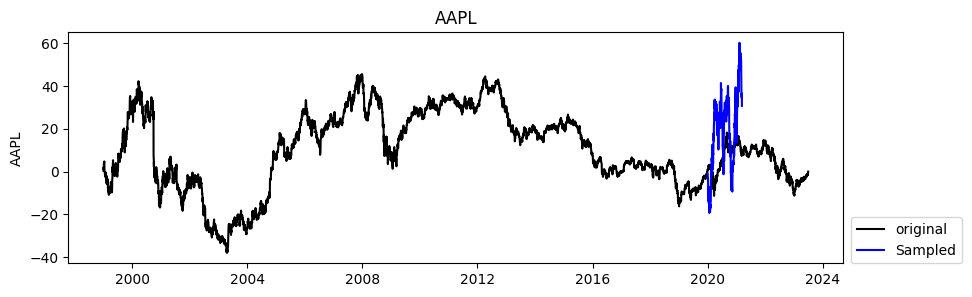

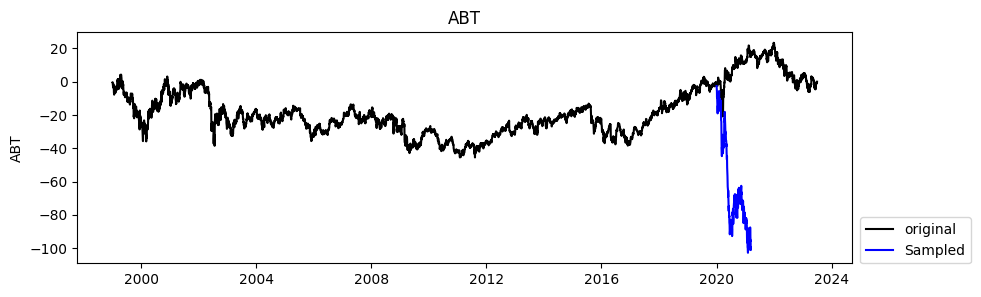

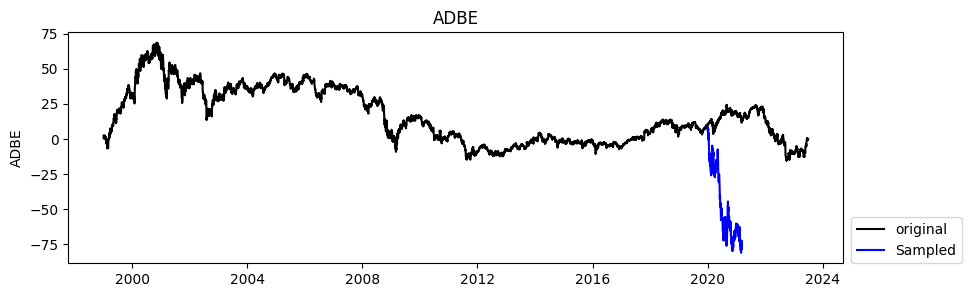

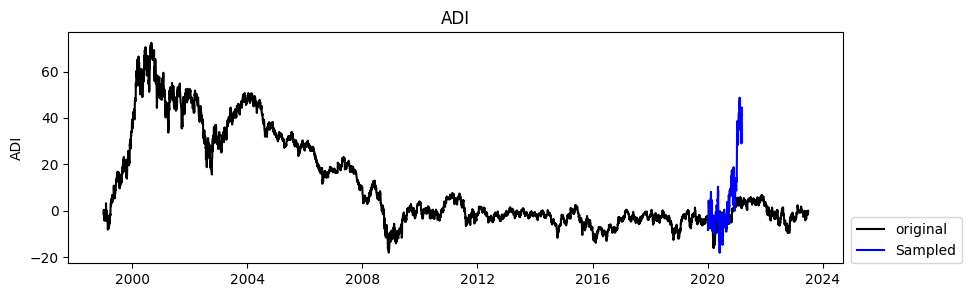

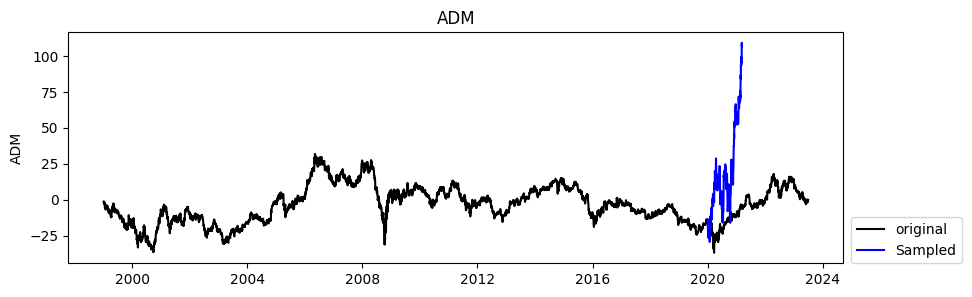

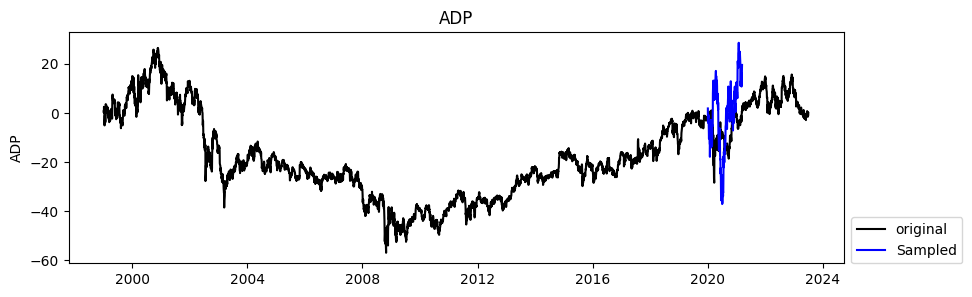

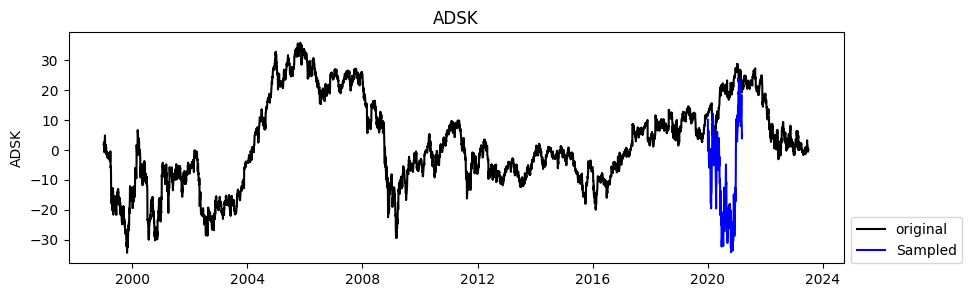

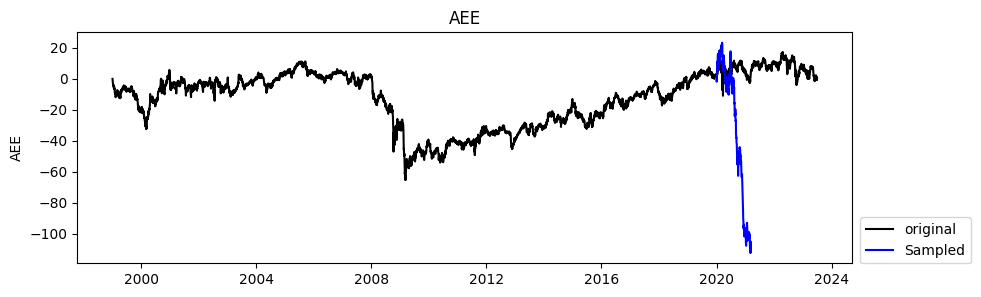

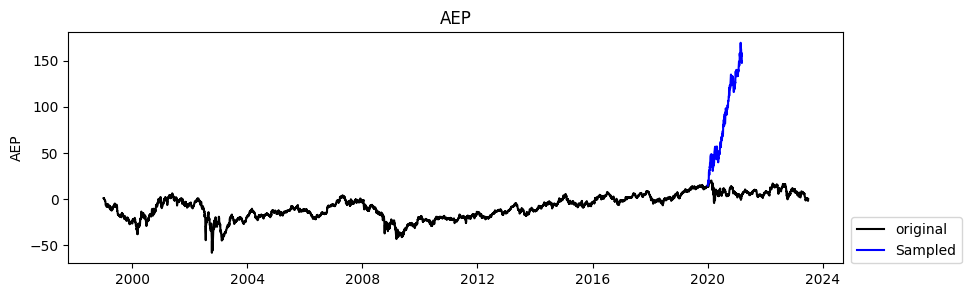

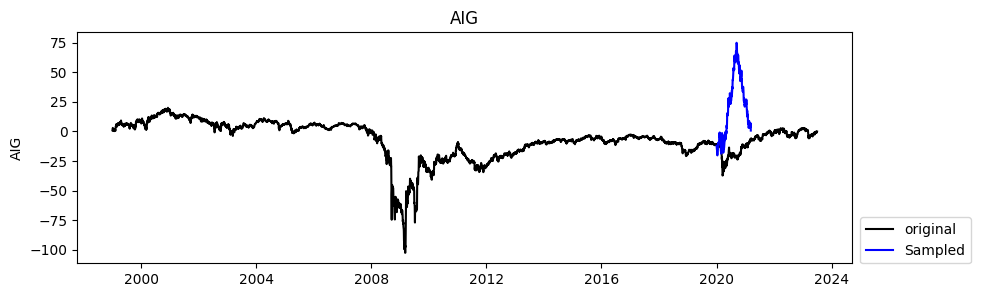

In [89]:
columns = df_orig.columns.tolist()
starting_point = df_orig[:end_year].cumsum().dropna().iloc[-1]
plot_data(df_orig, synth_data, starting_point, columns[:10])

In [90]:
import sdv
import sdv.evaluation.single_table as sdv_st
from sdv.metadata import SingleTableMetadata

true_data = df_orig[df.isna()].dropna()
synthetic_data = synth_data[df.isna()].dropna()

# build a metadata for evaluation (from SDV)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=true_data)
# generate quality report
quality_report = sdv_st.evaluate_quality(
    real_data=true_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)


NameError: name 'df' is not defined

In [ ]:
from evaluation_metrics import kl_divergence_columns, kl_divergence_rows, wasserstein_distance_columns, wasserstein_distance_rows, compute_frobenius_norm, compute_condition_number, compute_spectral_norm

In [ ]:
kl_col = kl_divergence_columns(synthetic_data,true_data)
kl_rows = kl_divergence_rows(synthetic_data,true_data)
wasserstein_col = wasserstein_distance_columns(synthetic_data,true_data)
wasserstein_rows = wasserstein_distance_rows(synthetic_data,true_data)


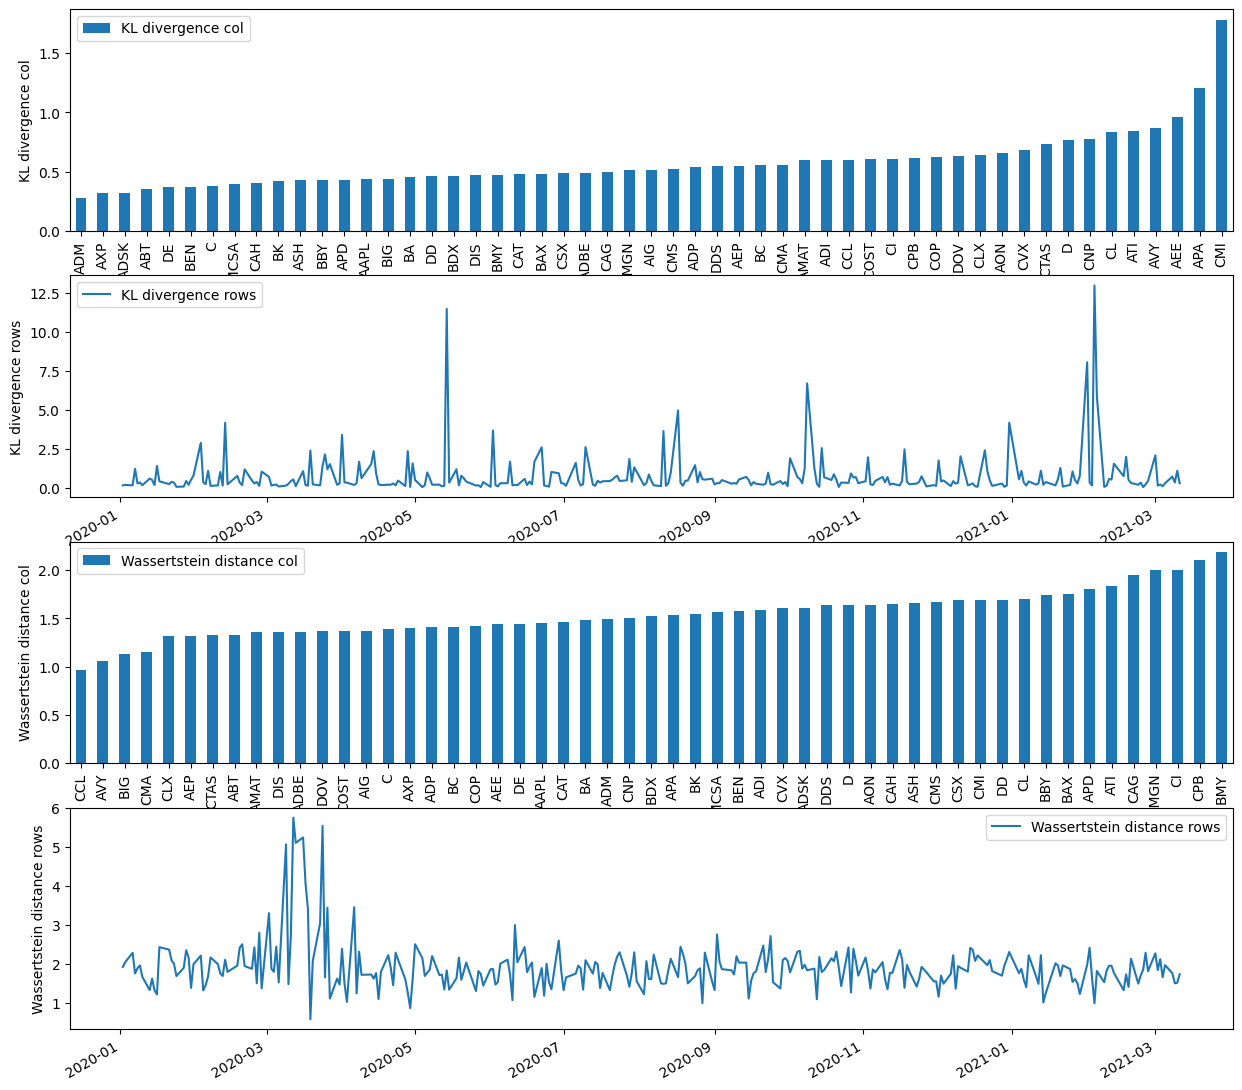

In [ ]:

fig,axes = plt.subplots(nrows=4,ncols = 1,figsize = (15,15))
metrics = [kl_col,kl_rows,wasserstein_col, wasserstein_rows]
for i,ax in enumerate(axes):
    to_plot = metrics[i]
    title = to_plot.columns.tolist()[0]
    to_plot = to_plot.sort_values(by = title)
    if 'rows' in title:
        to_plot.plot(ax = axes[i],kind ='line')
    else :
        to_plot.plot(ax = axes[i],kind ='bar')
    axes[i].set_ylabel(title)


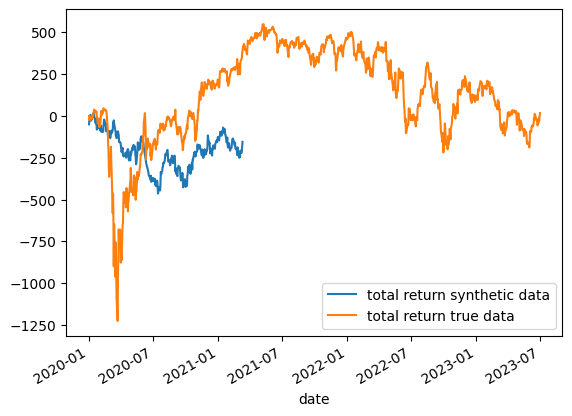

In [ ]:
synthetic_data.cumsum().sum(1).plot(label = 'total return synthetic data')
true_data.cumsum().sum(1).plot(label = 'total return true data')
plt.legend()

Frobenius Norm: 79.35351262980964
Spectral Norm: 25.773572972838245
Condition Number - True Data: 299.3911090299096
Condition Number - Synthetic Data: 77.3578031712844


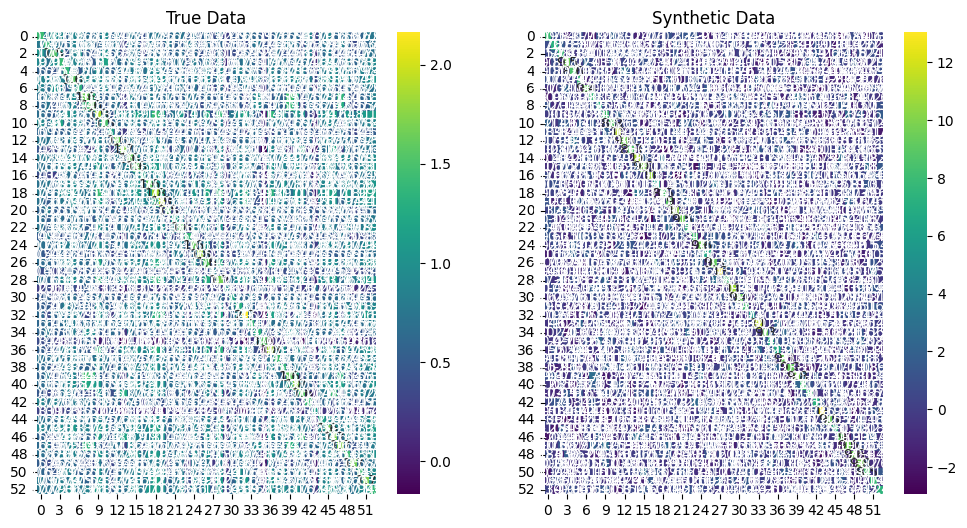

In [ ]:
cov_matrix_true = np.cov(true_data, rowvar=False)
cov_matrix_synthetic = np.cov(synthetic_data, rowvar=False)


# Calculate metrics
frobenius_norm = compute_frobenius_norm(cov_matrix_true, cov_matrix_synthetic)
spectral_norm = compute_spectral_norm(cov_matrix_true, cov_matrix_synthetic)
condition_number_true = compute_condition_number(cov_matrix_true)
condition_number_synthetic = compute_condition_number(cov_matrix_synthetic)

# Print metrics
print(f"Frobenius Norm: {frobenius_norm}")
print(f"Spectral Norm: {spectral_norm}")
print(f"Condition Number - True Data: {condition_number_true}")
print(f"Condition Number - Synthetic Data: {condition_number_synthetic}")



In [ ]:
from plot_results import plot_covariance_matrices, plot_eigenvalues
# Plot covariance matrices
plot_covariance_matrices(cov_matrix_true, cov_matrix_synthetic)


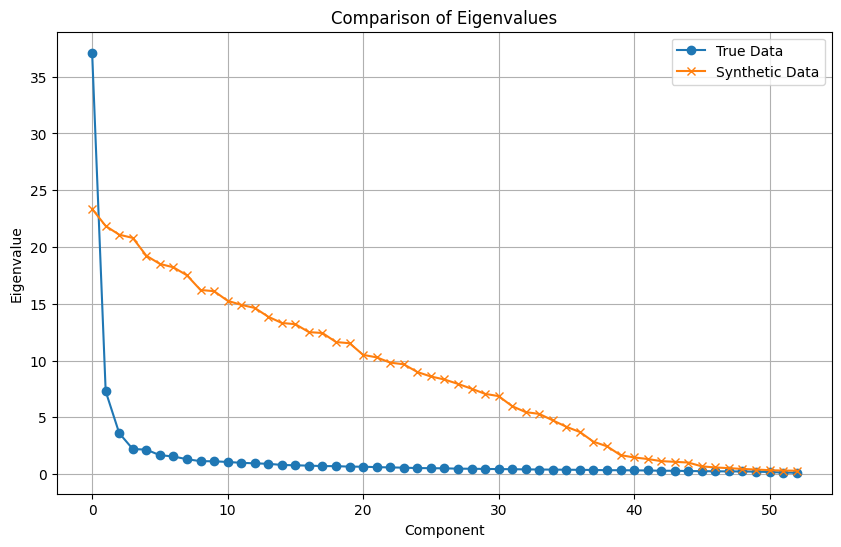

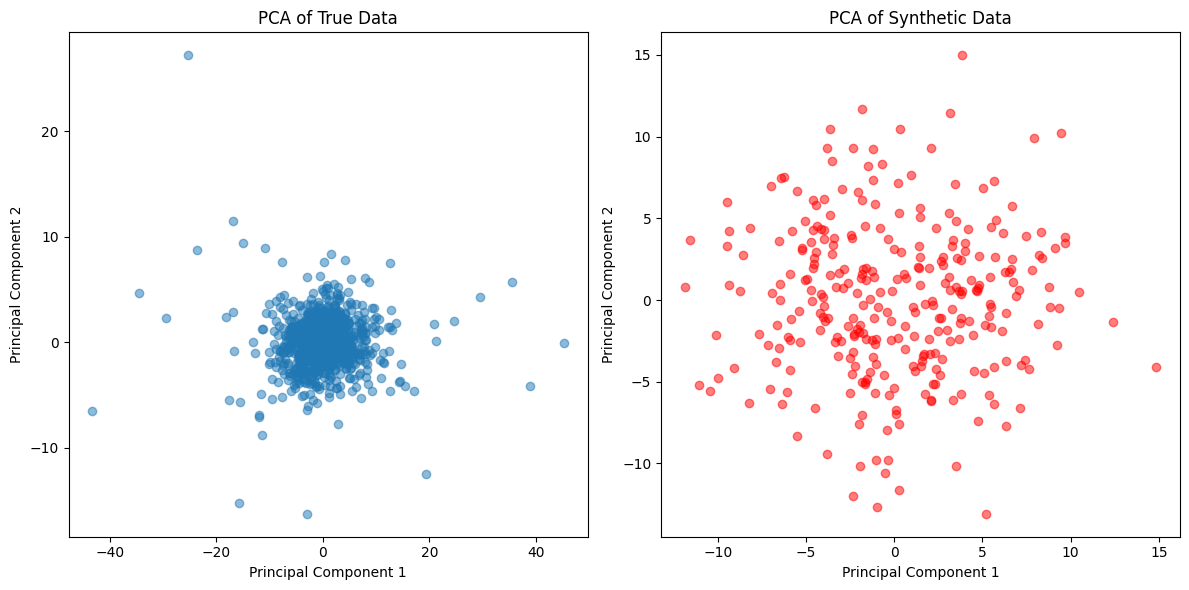

In [ ]:
from evaluation_metrics import eigen_decomposition, plot_eigenvalues
# Eigenvalue decomposition
eigenvalues_true, eigenvectors_true = eigen_decomposition(cov_matrix_true)
eigenvalues_synthetic, eigenvectors_synthetic = eigen_decomposition(cov_matrix_synthetic)

# Plot eigenvalues
plot_eigenvalues(eigenvalues_true, eigenvalues_synthetic)


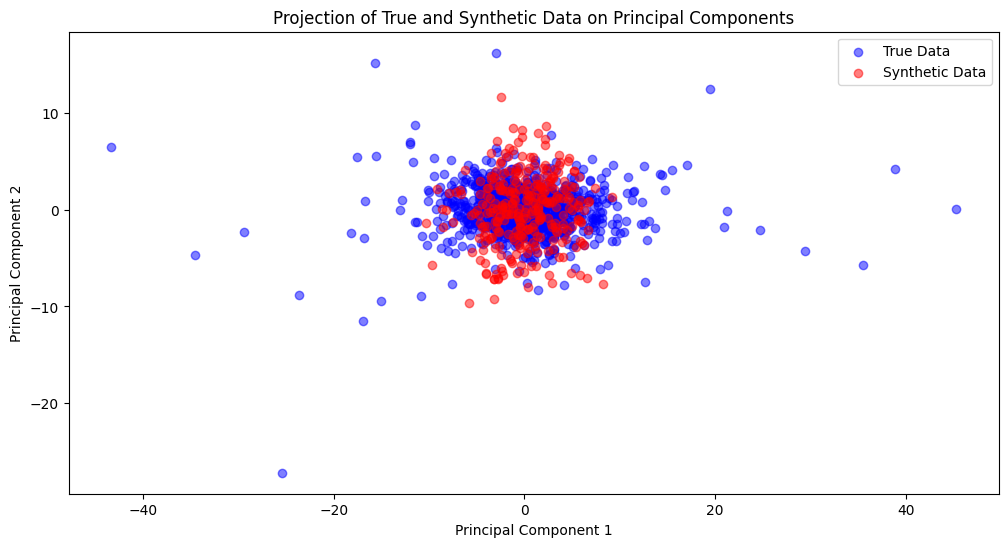

In [ ]:
from evaluation_metrics import compute_principal_components, project_onto_principal_components
from plot_results import plot_projection_on_principal_components


# Compute principal components from true data
_, eigenvectors_true = compute_principal_components(true_data)

# Project both true and synthetic data onto these principal components
projection_true = project_onto_principal_components(true_data, eigenvectors_true)
projection_synthetic = project_onto_principal_components(synthetic_data, eigenvectors_true)

# Visualize the projections
plot_projection_on_principal_components(projection_true, projection_synthetic)
